### Introduction - Measuring Market Risk in Python ###

VAR or ES are common terms that one would usually come across in finance when it comes to the measurement of market risks.

VAR, or Value At Risk, is basically a measure of the potential losses that one could face, at a specific level of confidence - e.g. 99%. But before we get into VAR, we first need to discuss what value we are assessing risk against. What we want to measure would be the change in market prices over a time period (e.g. day to day). So what VAR would then tell us then would be how much we could lose (or gain) due to the change in prices.

It's quite common to use lognormal instead of normal returns when computing the change in prices. Useful links which provide more information on the difference between the two -

- https://quantivity.wordpress.com/2011/02/21/why-log-returns/
- http://www.insight-things.com/log-normal-distribution-mistaken

Essentially, a few points to note -
> 
* We assume prices are lognormal, then the log returns are normally distributed.
* When returns are small, it is hard to tell the difference between a lognormal and normal distribution
* Lognormal allows us, when compounding, to simply add returns (rather than multiplying). The sum of log returns then simply becomes the difference in the log of final and initial price.


We will compute relative returns and lognormal returns for FX and equity prices. As daily returns are not large, the difference for FX is close to indiscernible, and just slightly for equity returns.

We will use FX and equity data freely available from Quandl.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

from scipy import stats
import numpy as np
import pandas as pd
import quandl

In [2]:
fx_list = ['CUR/JPY', 'CUR/GBP', 
           'CUR/EUR', 'CUR/CHF']

In [3]:
# Get your own key from Quandl and add here
quandl.ApiConfig.api_key = ""

In [4]:
start = pd.datetime(2010,1,1)

In [5]:
end = pd.datetime(2018,1,1)

In [6]:
dates = pd.date_range(start, end)

In [7]:
FX_DF = pd.DataFrame(index=dates)
for code in fx_list:
    FX_DF[code] = quandl.get(code, start_date=start, end_date=end)

First, let's just plot the distribution of actual price levels.

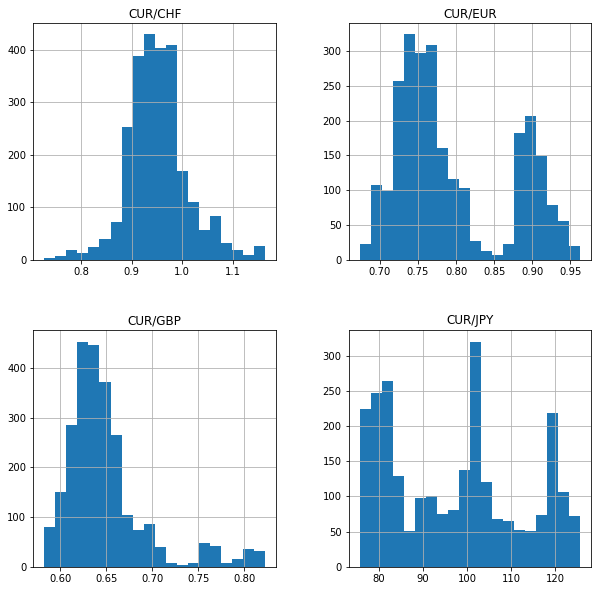

In [8]:
FX_DF.hist(bins=20, figsize=(10,10))
plt.show()

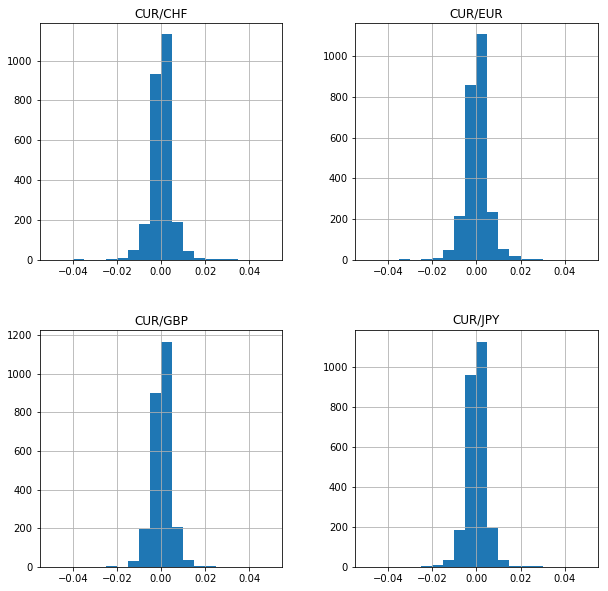

In [9]:
FX_Returns = (FX_DF/FX_DF.shift(1))-1
FX_Returns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

Now, let's look at the log returns.

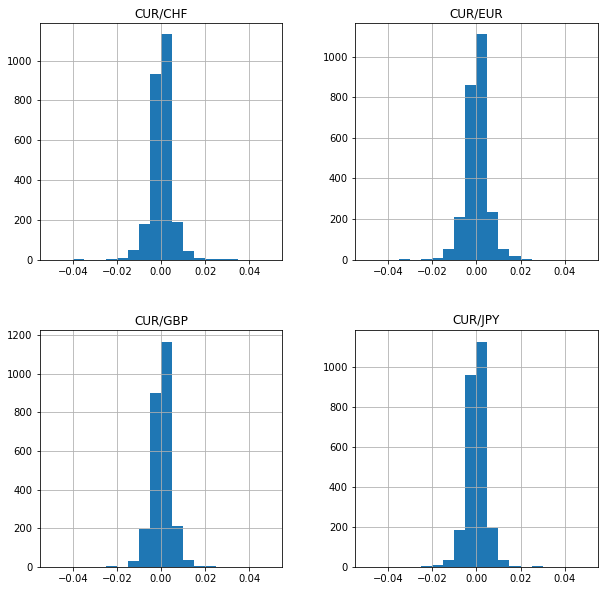

In [10]:
FX_DF_LogReturns = np.log(FX_DF/FX_DF.shift(1))
FX_DF_LogReturns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

In [11]:
eq_list = ['EOD/MSFT', 'EOD/AAPL', 'EOD/MMM', 'EOD/MCD']
EQ_DF = pd.DataFrame(index=dates)
for code in eq_list:
    EQ_DF[code] = quandl.get(code, start_date=start, end_date=end).Close

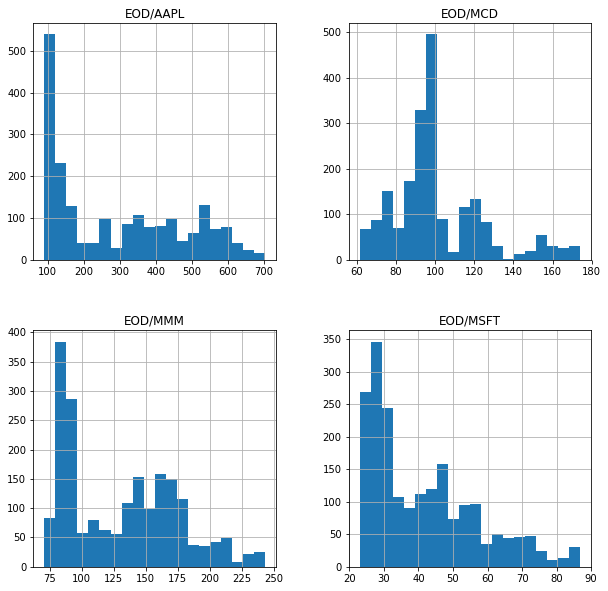

In [12]:
EQ_DF.hist(bins=20, figsize=(10,10))
plt.show()

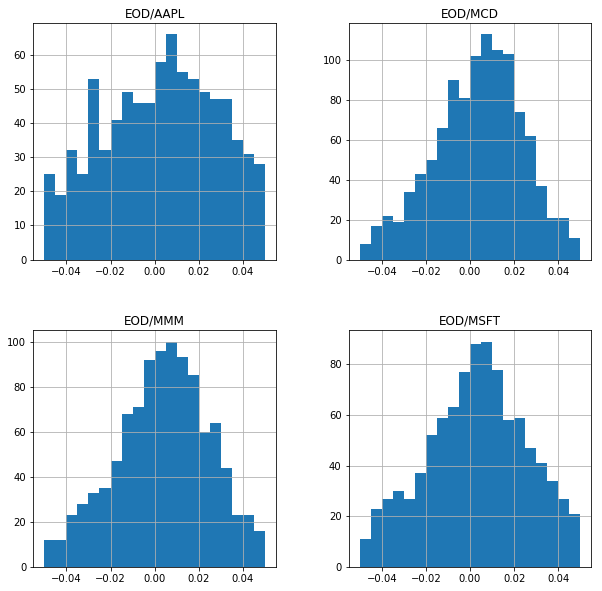

In [13]:
EQ_Returns = (EQ_DF/EQ_DF.shift(10))-1
EQ_Returns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

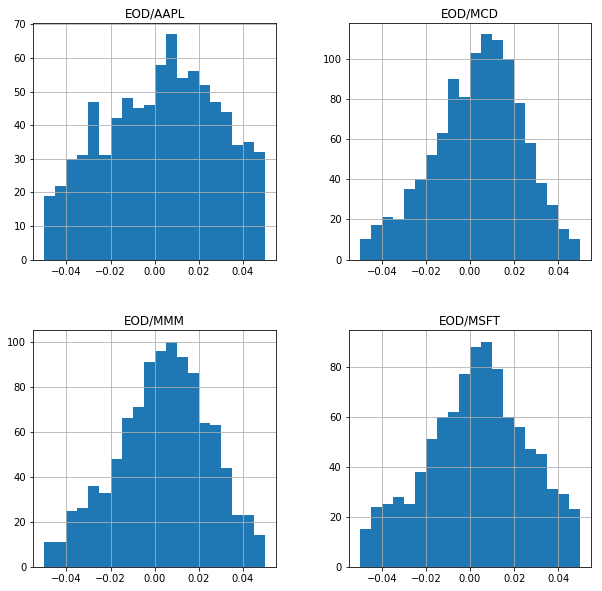

In [14]:
EQ_DF_LogReturns = np.log(EQ_DF/EQ_DF.shift(10))
EQ_DF_LogReturns.hist(bins=20, range=(-0.05, 0.05), figsize=(10,10))
plt.show()

### Value at Risk ###

There's nothing very complicated about Value at Risk (VAR). To put it simply, it's simply a single metric that shows the potential losses of a portfolio etc (at different confidence levels). There are two main methods to compute VAR -
* Parametric
* Historical 

** Parametric VAR **

Very often, the parametric VAR is based on a normal distribution. Plotting a normal distribution and the VAR on a chart will give us a good overview of how this works.

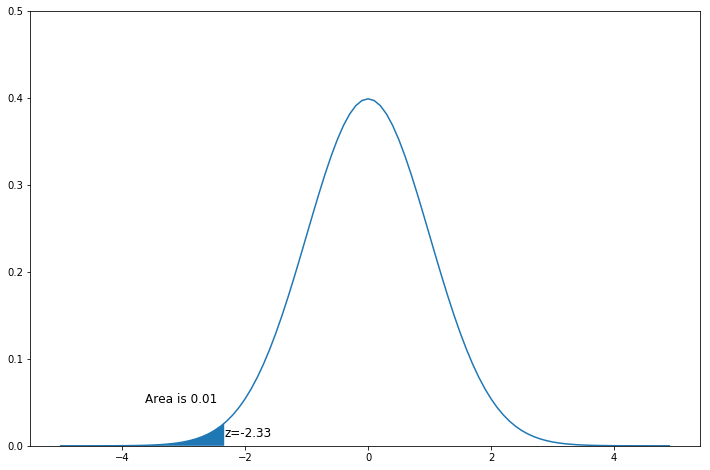

In [15]:
# We use z to define how many standard deviations away from the mean
# Here we use z = -2.33 to get to a 99% confidence interval. Why 99% will be obvious once we plot out the distribution
z = -2.33

plt.figure(figsize=(12,8))
# plotting the normal distribution, using the scipy stats norm function
plt.ylim(0, 0.5)
x = np.arange(-5,5,0.1)
y1 = stats.norm.pdf(x)
plt.plot(x, y1)

x2 = np.arange(-5, z, 0.01) # we use this range from the -ve end to -2.33 to compute the area
sum = 0
# s = np.arange(-10,z,0.01)
for i in x2:
    sum+=stats.norm.pdf(i)*0.01 # computing area under graph from -5 to -2.33 in steps of 0.01

plt.annotate('Area is ' + str(round(sum,3)), xy = (z-1.3, 0.05), fontsize=12)
plt.annotate('z=' + str(z), xy=(z, 0.01), fontsize=12)
plt.fill_between(x2, stats.norm.pdf(x2))
plt.show()

Once you understand what VAR and confidence levels mean (from the chart above), getting the z for different confidence levels is simple, and is the basis for computing parametric VAR.

In [16]:
z_95 = stats.norm.ppf(1-0.95)
z_99 = stats.norm.ppf(1-0.99)
z_999 = stats.norm.ppf(1-0.999)

print('95%, 99%, 99.9% Z =', z_95, z_99, z_999)

95%, 99%, 99.9% Z = -1.64485362695 -2.32634787404 -3.09023230617


The general formula is -
> $ VAR = position * (\mu_{period} + z*\sigma_p) $ 

When period is short, say 1 day, then $\mu_{period}$ is small, and the above becomes
> $VAR = position * z * \sigma_p$

Let's compute the VAR for the equity prices we obtained from Quandl earlier

In [17]:
confidence = 0.99
Z = stats.norm.ppf(1-confidence)
mean = np.mean(EQ_Returns)
stddev = np.std(EQ_Returns)

The VAR for the latest prices is then ...

In [18]:
EQ_DF.dropna().iloc[-1,:]*Z*stddev

EOD/MSFT    -7.288313
EOD/AAPL   -26.516812
EOD/MMM    -15.769323
EOD/MCD     -9.409525
dtype: float64

** Historical VAR **

Historical VAR is even simpler. We simply get the return at the right percentile and apply the same formula to the latest prices.

In [19]:
print(EQ_DF.dropna().iloc[-1,:]*np.percentile(EQ_Returns.dropna(), 1))

EOD/MSFT    -8.097142
EOD/AAPL   -16.019164
EOD/MMM    -22.279918
EOD/MCD    -16.292729
Name: 2017-12-29 00:00:00, dtype: float64
